# **Setup**

In [1]:
import kagglehub
path = kagglehub.dataset_download("mdriyadhossain/ai-medleafx")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-medleafx


# **Import**

In [2]:
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import imagehash, seaborn as sns

base = Path('/kaggle/input/ai-medleafx/Resized Image')
sns.set(style='whitegrid')


# **Gather Paths**

In [6]:
from itertools import chain
import pandas as pd

paths = []
for src in base.iterdir():
    for cls in src.iterdir():
        for img in chain(cls.glob('*.jpg'), cls.glob('*.JPG')):
            paths.append((str(img), src.name, cls.name))

df = pd.DataFrame(paths, columns=['path', 'source', 'class'])

# Group by 'class' and count
class_counts = df.groupby('class').size()
print(class_counts)

# Sum the total count
total_count = class_counts.sum()
print("Total count:", total_count)


class
Bacterial Spot    2408
Healthy Leaf      3497
Powdery Mildew     854
Shot Hole         1597
Shot Hole Leaf     834
Yellow Leaf       1668
dtype: int64
Total count: 10858


# **Extract Core Stats**

In [7]:
rows=[]
for p,s,c in tqdm(paths):
    img = cv2.imread(p)
    if img is None: continue
    h,w = img.shape[:2]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    mean_rgb = rgb.mean(axis=(0,1)); std_rgb = rgb.std(axis=(0,1))
    mean_hsv = hsv.mean(axis=(0,1)); std_hsv = hsv.std(axis=(0,1))
    brightness, contrast = mean_hsv[2], std_hsv[2]
    sat_low = np.mean(hsv[:,:,1]<=1); sat_high = np.mean(hsv[:,:,1]>=254)
    sharp = cv2.Laplacian(gray, cv2.CV_64F).var()
    blur = cv2.GaussianBlur(gray,(5,5),0)
    noise = (gray-blur).std()
    phash = str(imagehash.phash(Image.fromarray(rgb)))
    rows.append([p,s,c,w,h,w/h,*mean_rgb,*std_rgb,*mean_hsv,*std_hsv,brightness,contrast,sat_low,sat_high,sharp,noise,phash])

cols = ['path','source','class','w','h','aspect','r_mean','g_mean','b_mean','r_std','g_std','b_std','h_mean','s_mean','v_mean','h_std','s_std','v_std','brightness','contrast','sat_low','sat_high','sharp','noise','phash']
stats = pd.DataFrame(rows, columns=cols)


100%|██████████| 10858/10858 [18:42<00:00,  9.67it/s]


# **RGB/HSV Distributions**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

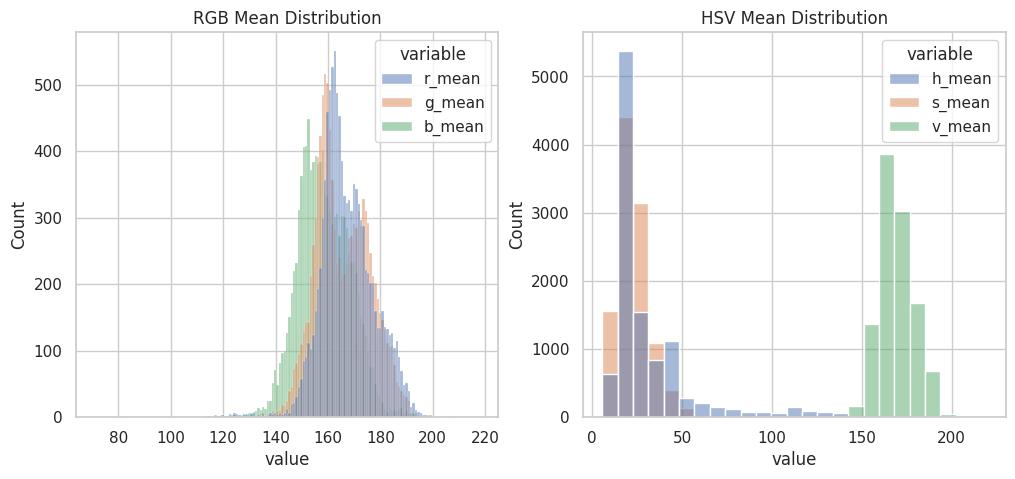

In [8]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot(stats[['r_mean','g_mean','b_mean']].melt(),x='value',hue='variable',ax=ax[0])
ax[0].set_title('RGB Mean Distribution')
sns.histplot(stats[['h_mean','s_mean','v_mean']].melt(),x='value',hue='variable',ax=ax[1])
ax[1].set_title('HSV Mean Distribution')
plt.show()


**Color Channel Analysis of MedLeafX Dataset**

We performed an exploratory data analysis (EDA) of the color characteristics of the images in the MedLeafX dataset. Specifically, we analyzed the mean color values in both RGB and HSV color spaces.

**RGB Mean Distribution**

The left plot shows the distribution of the mean Red, Green, and Blue (RGB) values across all images.

**Observation:**

R_mean (Red) values are centered around 160–180.

G_mean (Green) values cluster around 150–170.

B_mean (Blue) values are slightly lower, mostly around 140–160.

**Interpretation:**

The images have a generally warm tone, with red dominating slightly over blue.

This is typical for leaf datasets where green is strong but some images may include brown or red shades due to leaf disease or variation.

**HSV Mean Distribution**

The right plot shows the distribution of mean Hue (H), Saturation (S), and Value (V) for all images.

**Observation:**

H_mean (Hue) and S_mean (Saturation) are mostly concentrated at lower values (0–50), indicating that most pixels are in a greenish hue range but not very saturated.

V_mean (Value / brightness) is higher, mostly around 150–200, indicating overall bright images.

**Interpretation:**

The dataset has fairly bright leaf images with moderate color intensity.

Low Hue & Saturation but high Value suggests a dominance of lighter green tones.

# **Brightness / Contrast / Saturation Clipping**

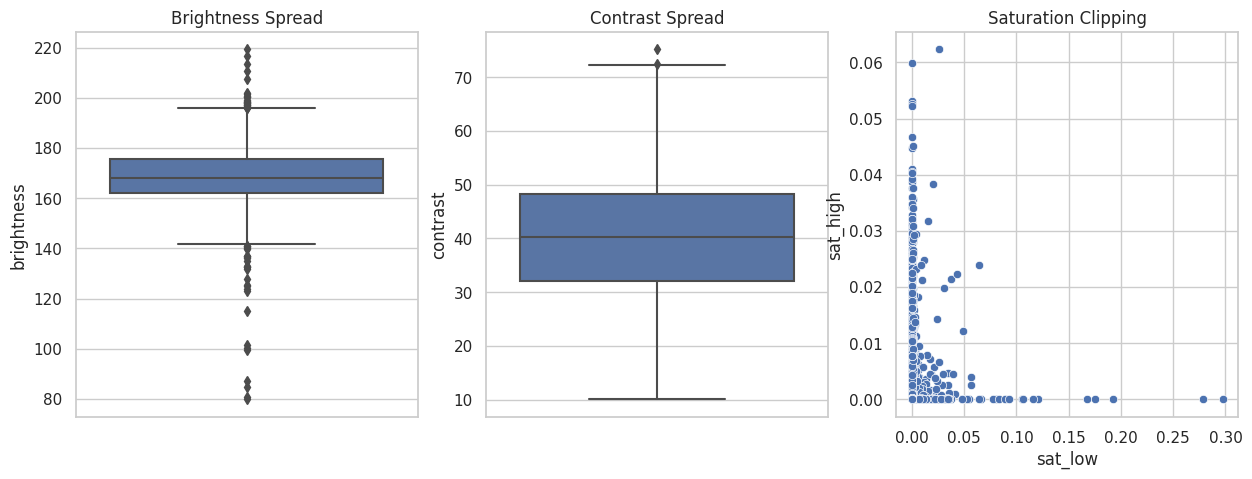

In [9]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(y=stats['brightness'],ax=ax[0]); ax[0].set_title('Brightness Spread')
sns.boxplot(y=stats['contrast'],ax=ax[1]); ax[1].set_title('Contrast Spread')
sns.scatterplot(x='sat_low',y='sat_high',data=stats,ax=ax[2]); ax[2].set_title('Saturation Clipping')
plt.show()


**Brightness Spread (Left Boxplot)**

**Interpretation:**

The median brightness is around 165–170, meaning most images are moderately bright.

There are many outliers on both ends — some images are too dark (below 100) and some too bright (above 200).

This suggests uneven lighting conditions or varying exposure in the dataset.

Insight: If this dataset is for machine learning or image recognition, normalization of brightness might be needed to ensure consistent model performance.

**Contrast Spread (Middle Boxplot)**

**Interpretation:**

The median contrast is around 40, with most values between 30–50.

A few outliers have very low contrast (~10–15) or very high (~70+).

Indicates that some images are washed out or overly sharp, but most have decent contrast.

**Insight:** Contrast normalization or histogram equalization might improve overall dataset uniformity.

Saturation Clipping (Right Scatter Plot)

**Feature:** Saturation clipping (sat_low vs sat_high)

**sat_low:** Fraction of pixels with very low saturation (nearly grayscale).

**sat_high**: Fraction of pixels with extremely high saturation (overly vivid colors).

**Interpretation:**

Most points are clustered near (0, 0) — meaning few images have excessive saturation issues.

A few images have slightly higher sat_low values, implying they are desaturated or dull.

**Insight:** The dataset generally has balanced color saturation, with minor cases of desaturation.

# **Resolution & Aspect Ratio**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


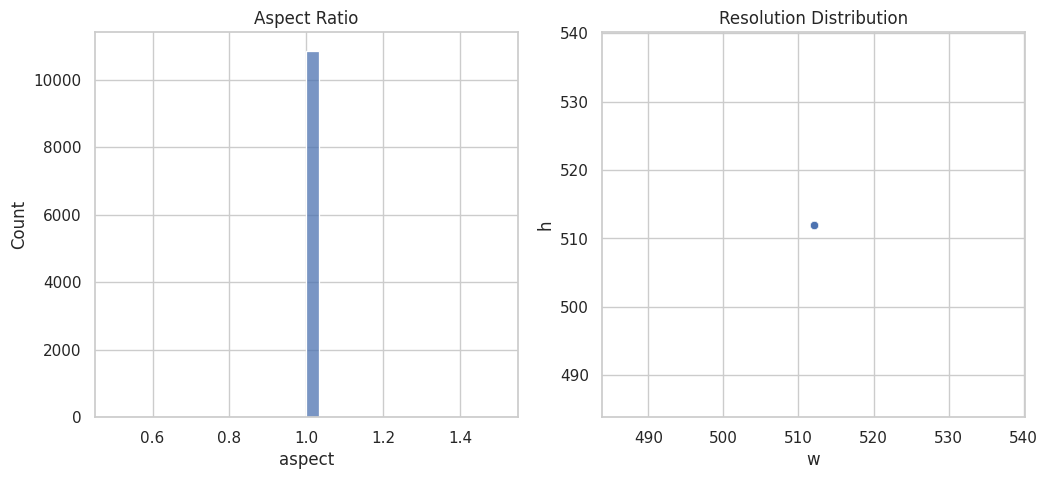

In [10]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot(stats['aspect'],bins=30,ax=ax[0]); ax[0].set_title('Aspect Ratio')
sns.scatterplot(x='w',y='h',data=stats,ax=ax[1]); ax[1].set_title('Resolution Distribution')
plt.show()


# **Sharpness & Noise**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


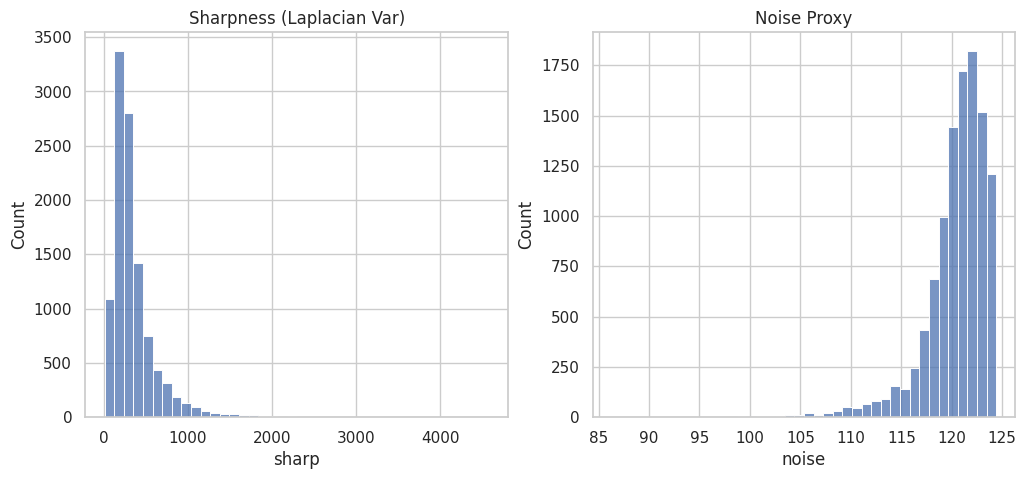

In [11]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
sns.histplot(stats['sharp'],bins=40,ax=ax[0]); ax[0].set_title('Sharpness (Laplacian Var)')
sns.histplot(stats['noise'],bins=40,ax=ax[1]); ax[1].set_title('Noise Proxy')
plt.show()


**Sharpness (Laplacian Variance) – Left Histogram**

**Feature:** Sharpness (measured via Laplacian variance — a common edge-detection-based metric).

**Interpretation:**

The distribution is heavily right-skewed, meaning most images have low sharpness values, with a few having very high sharpness (outliers).

A Laplacian variance near 0–500 indicates blurry or low-detail images, while higher values (e.g., >1000) mean clear, well-focused images.

Since most data points lie in the lower range, your dataset likely includes many slightly blurred or low-detail images.

**Insight:** It may be necessary to remove or enhance blurry samples for tasks that depend on fine texture or edge detail.

**Noise Proxy – Right Histogram**

**Feature:** Noise level proxy (a numerical estimate of random pixel intensity variation).

**Interpretation:**

The distribution is narrow and roughly normal, centered around 120.

This indicates that most images have consistent noise levels, with only a few being significantly noisier or smoother.

The range (≈85–125) suggests low to moderate noise across the dataset.

**Insight:** The dataset maintains a fairly uniform noise profile, so noise likely won’t strongly bias model performance.

# **White Balance (Gray-World Check)**

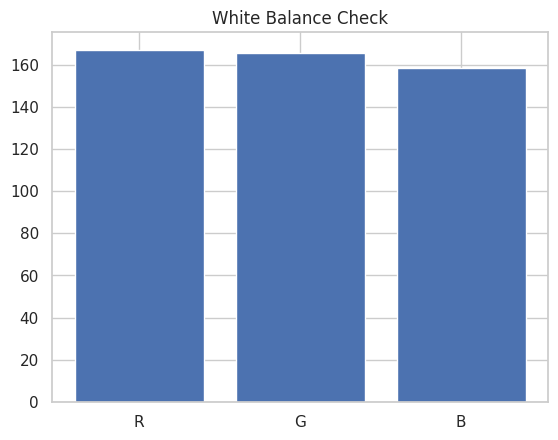

RGB mean ratio: r_mean    1.020999
g_mean    1.011124
b_mean    0.967876
dtype: float64


In [12]:
avg_rgb = stats[['r_mean','g_mean','b_mean']].mean()
plt.bar(['R','G','B'], avg_rgb); plt.title('White Balance Check'); plt.show()
print('RGB mean ratio:', avg_rgb/avg_rgb.mean())


**Insight**: The dataset shows a minor red-green dominance and a slight blue deficiency, which could give images a warm (reddish-yellow) tint. However, the deviation is relatively small and unlikely to cause major visual distortions. Color balance is mostly consistent across the dataset, with only a slight warm bias due to stronger red and green components so white balance is close to neutral.

# **Duplicate Detection**

In [13]:
dupes = stats[stats.duplicated('phash',keep=False)].sort_values('phash')
dupes.head(10)

path  source  \
564   /kaggle/input/ai-medleafx/Resized Image/Sojina...  Sojina   
163   /kaggle/input/ai-medleafx/Resized Image/Sojina...  Sojina   
66    /kaggle/input/ai-medleafx/Resized Image/Sojina...  Sojina   
4260  /kaggle/input/ai-medleafx/Resized Image/Neem/H...    Neem   
3560  /kaggle/input/ai-medleafx/Resized Image/Neem/Y...    Neem   
5920  /kaggle/input/ai-medleafx/Resized Image/Neem/S...    Neem   
5941  /kaggle/input/ai-medleafx/Resized Image/Neem/S...    Neem   
5457  /kaggle/input/ai-medleafx/Resized Image/Neem/S...    Neem   
5800  /kaggle/input/ai-medleafx/Resized Image/Neem/S...    Neem   
4808  /kaggle/input/ai-medleafx/Resized Image/Neem/H...    Neem   

               class    w    h  aspect      r_mean      g_mean      b_mean  \
564      Yellow Leaf  512  512     1.0  156.369686  152.919476  146.892197   
163      Yellow Leaf  512  512     1.0  159.226933  155.918411  149.662823   
66       Yellow Leaf  512  512     1.0  160.028275  156.220810  149.785942   
4260    Healthy Leaf  512  512     1.0  177.550468  176.120110  165.834450   
3560     Yellow Leaf  512  512     1.0  194.363499  189.378063  182.123089   
5920  Shot Hole Leaf  512  512     1.0  178.933041  174.906815  166.188545   
5941  Shot Hole Leaf  512  512     1.0  178.951237  175.286026  166.170212   
5457  Shot Hole Leaf  512  512     1.0  174.176731  173.208309  166.241268   
5800  Shot Hole Leaf  512  512     1.0  176.345886  172.500069  165.075932   
4808    Healthy Leaf  512  512     1.0  161.201115  157.246082  154.578640   

          r_std  ...      h_std      s_std      v_std  brightness   contrast  \
564   16.048074  ...   2.554639  18.383691  16.048339  156.370148  16.048339   
163   15.953504  ...   2.741270  21.067908  15.953264  159.227245  15.953264   
66    14.953594  ...   2.228038  17.617027  14.953624  160.028305  14.953624   
4260  44.495581  ...   4.340096  21.134282  43.544244  177.936016  43.544244   
3560  29.891815  ...   8.257076  28.132905  29.441090  194.516464  29.441090   
5920  36.900441  ...   4.699028  17.843400  36.260684  179.137226  36.260684   
5941  36.734594  ...   4.332454  18.030253  36.041645  179.174622  36.041645   
5457  38.919710  ...   5.630523  24.262923  37.332015  174.813869  37.332015   
5800  37.685482  ...   5.960229  23.839955  36.331709  176.865555  36.331709   
4808  35.025147  ...  19.903435  16.821394  34.119142  161.501862  34.119142   

       sat_low  sat_high       sharp       noise             phash  
564   0.000000  0.000092  200.973521  122.894219  868c59f366cc9933  
163   0.000000  0.000034  179.011365  122.978653  868c59f366cc9933  
66    0.000000  0.000008  150.754179  122.804579  868c59f366cc9933  
4260  0.000000  0.000031  253.108419  120.907624  90904fcf3031cfcf  
3560  0.000000  0.000015  177.216589  119.145708  90904fcf3031cfcf  
5920  0.000000  0.000000  233.425481  120.105944  90c5c73c38c3ce3d  
5941  0.000000  0.000000  237.626122  120.765816  90c5c73c38c3ce3d  
5457  0.000015  0.000000  204.823730  121.056272  9184cce33398cfcd  
5800  0.000053  0.000000  166.904068  119.178679  9184cce33398cfcd  
4808  0.000000  0.000004  335.695382  121.311190  9fe0c01f3fe0c01f  

[10 rows x 25 columns]

# **Class Balance**

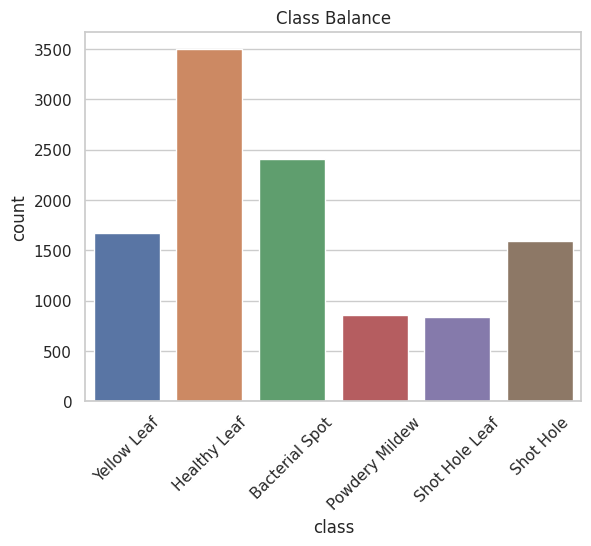

In [14]:
sns.countplot(x='class',data=stats); plt.title('Class Balance'); plt.xticks(rotation=45); plt.show()

# **Leakage Safeguards**

In [15]:
stats.groupby('source')['class'].nunique()


source
Camphor     3
HariTaki    3
Neem        4
Sojina      3
Name: class, dtype: int64

In [17]:
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(stats, groups=stats['source']))


# ** Augmentation Probe**

In [24]:
import cv2
import numpy as np
import os
import glob

# Define the directory where your images are stored
image_directory = '/kaggle/input/ai-medleafx/Resized Image'

# Get all image files in the directory and its subdirectories
image_files = glob.glob(os.path.join(image_directory, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(image_directory, '**', '*.jpeg'), recursive=True) + \
              glob.glob(os.path.join(image_directory, '**', '*.png'), recursive=True) +\
              glob.glob(os.path.join(image_directory, '**', '*.JPG'), recursive=True)

num_samples = 10
sample_images = []
sample_image_paths = []

# Loop through the image files and load the sample images
for i, img_path in enumerate(image_files):
    if len(sample_images) >= num_samples:
        break
    img = cv2.imread(img_path)
    if img is not None:
        sample_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for consistent visualization
        sample_image_paths.append(img_path)

print(f"Loaded {len(sample_images)} sample images.")

Loaded 10 sample images.


In [25]:
import random
import torchvision.transforms as transforms
from PIL import Image

def apply_random_crop(image, crop_size):
    """Applies a random crop to the image."""
    h, w, _ = image.shape
    th, tw = crop_size
    if w == tw and h == th:
        return image
    i = random.randint(0, h - th)
    j = random.randint(0, w - tw)
    return image[i:i+th, j:j+tw]

def apply_random_flip(image):
    """Applies a random horizontal or vertical flip to the image."""
    flip_type = random.choice(['none', 'horizontal', 'vertical'])
    if flip_type == 'horizontal':
        return np.fliplr(image)
    elif flip_type == 'vertical':
        return np.flipud(image)
    else:
        return image

def apply_color_jitter(image):
    """Applies random color jitter to the image."""
    # Convert numpy array to PIL Image for torchvision transforms
    pil_image = Image.fromarray(image)
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    jittered_image = color_jitter(pil_image)
    # Convert PIL Image back to numpy array
    return np.array(jittered_image)


def apply_random_blur(image, kernel_size):
    """Applies a Gaussian blur to the image."""
    # Ensure kernel_size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

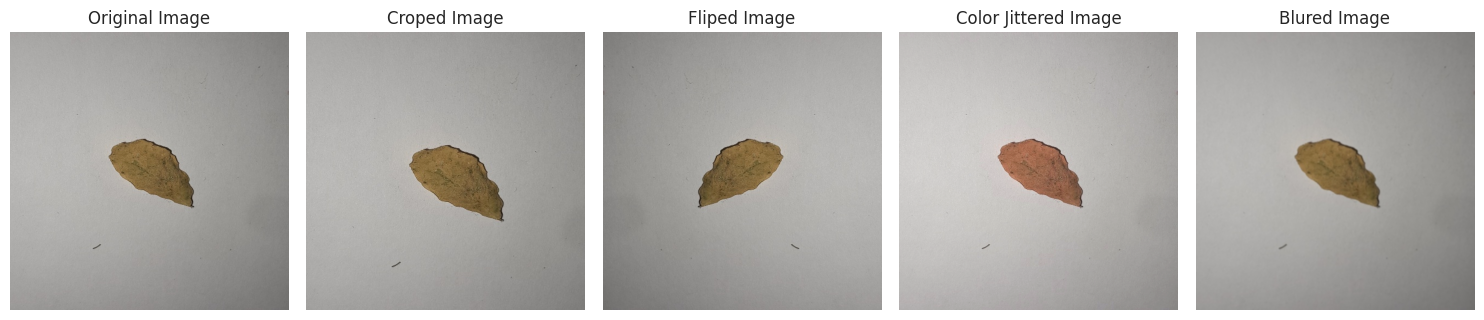

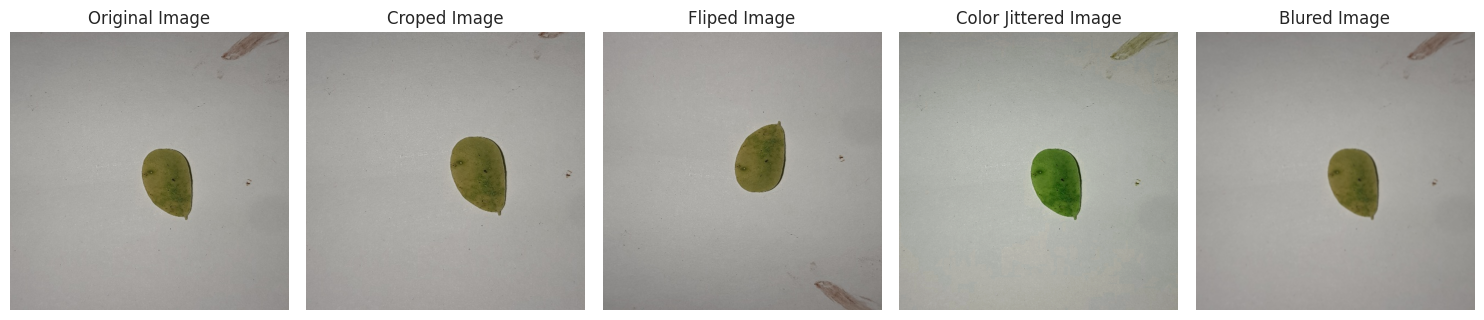

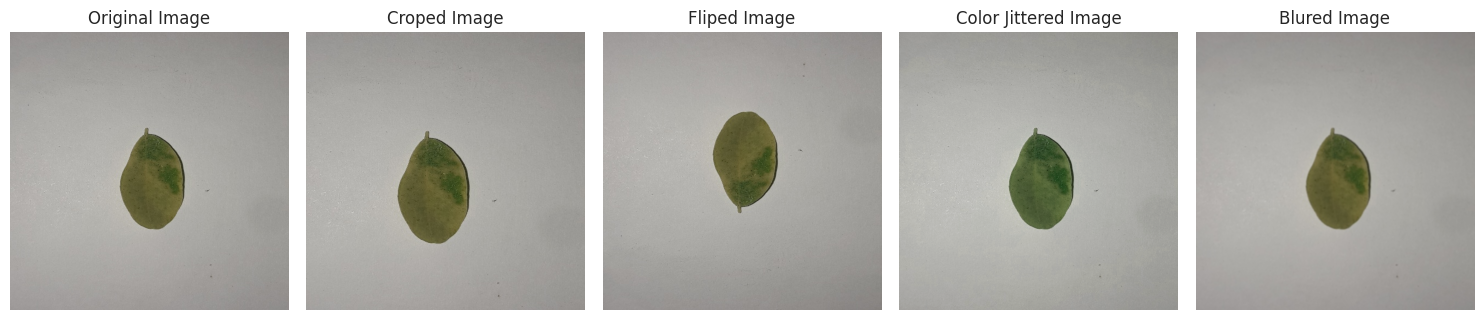

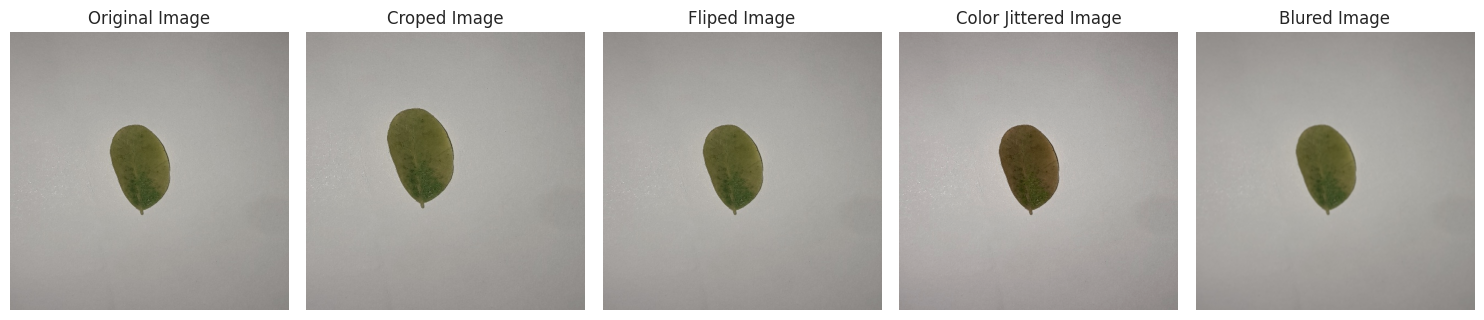

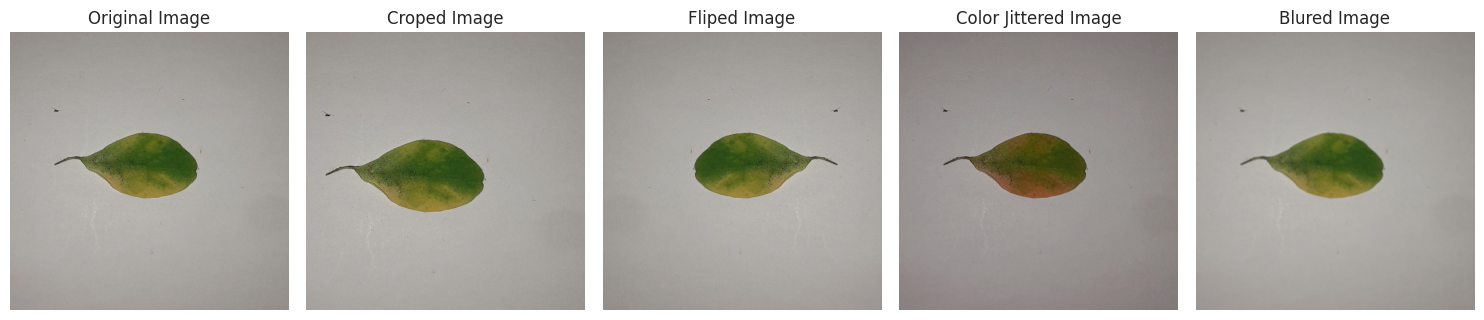

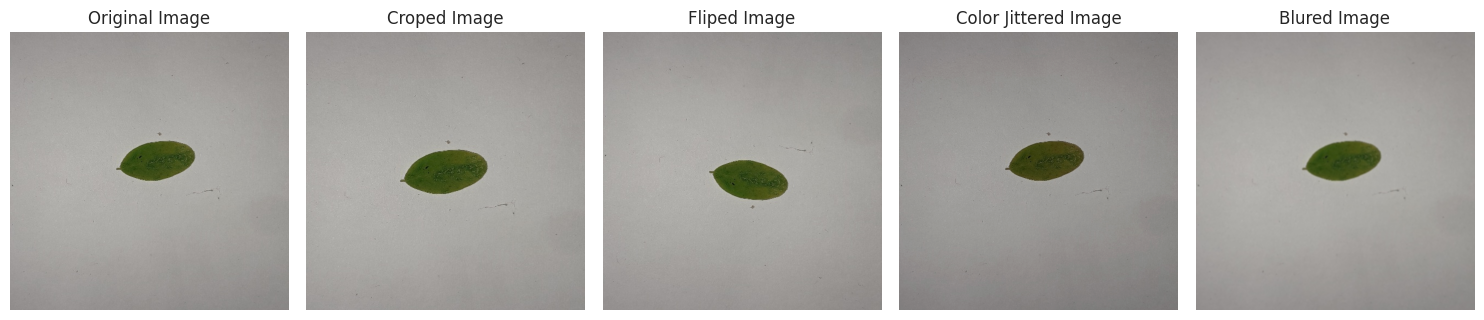

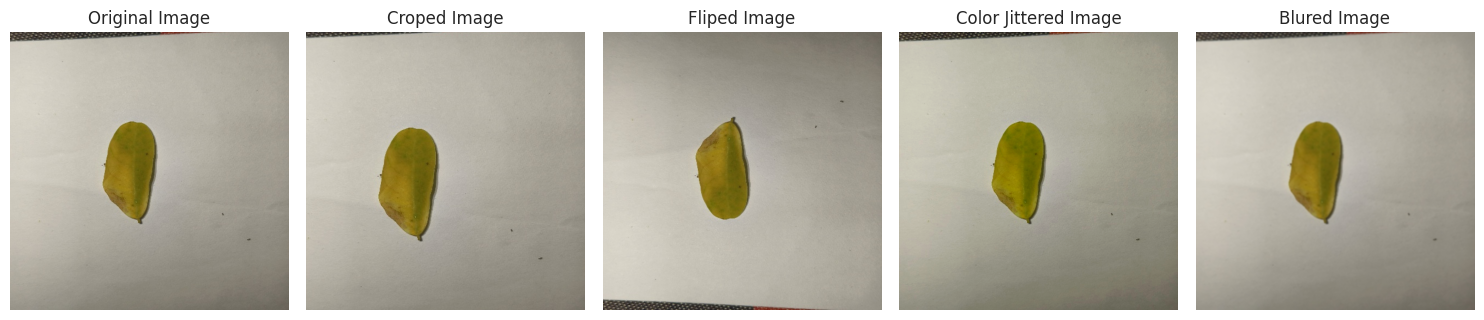

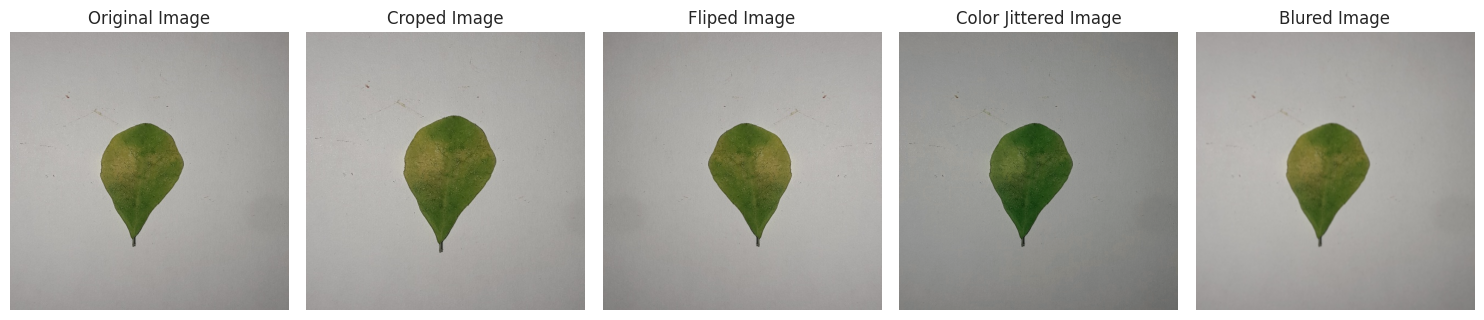

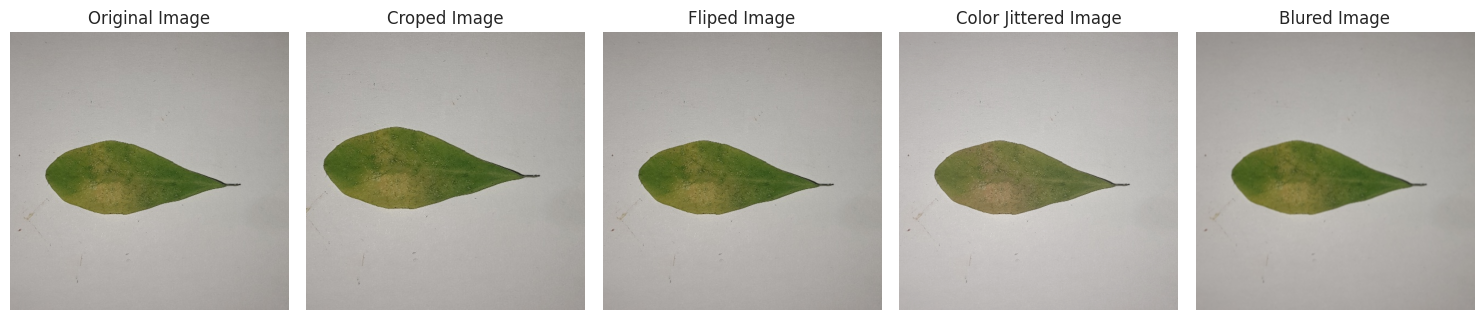

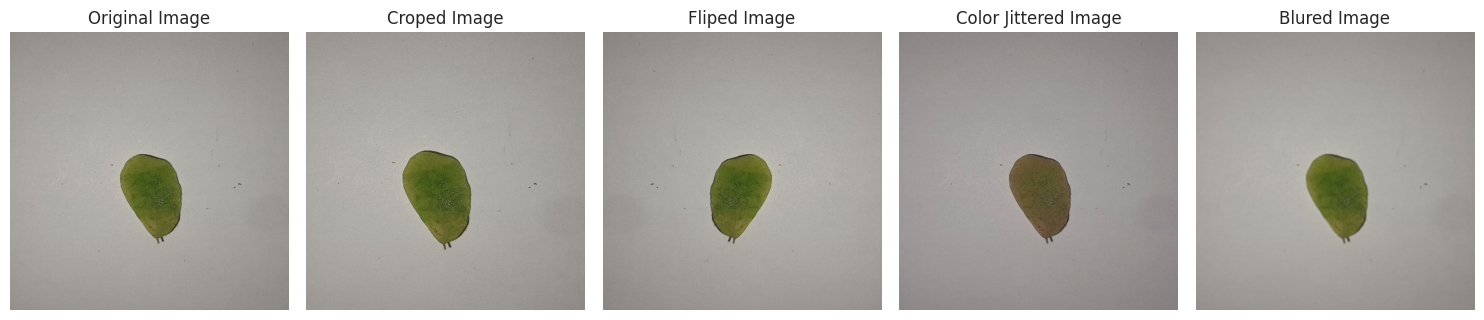

In [26]:
augmentations = {
    "Crop": lambda img: apply_random_crop(img, crop_size=(img.shape[0] - 50, img.shape[1] - 50)), # Example crop size
    "Flip": apply_random_flip,
    "Color Jitter": apply_color_jitter,
    "Blur": lambda img: apply_random_blur(img, kernel_size=5) # Example kernel size
}

for original_image in sample_images:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(augmentations) + 1, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    for i, (aug_name, aug_func) in enumerate(augmentations.items()):
        augmented_image = aug_func(original_image)
        plt.subplot(1, len(augmentations) + 1, i + 2)
        plt.imshow(augmented_image)
        plt.title(f"{aug_name}ed Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Summary

- > **Flip and Color Jitter appear to be generally promising augmentations for this dataset, introducing realistic variations that could improve model generalization.**
  
- > **Crop can be helpful but requires careful consideration of crop size and strategy to avoid removing important features.**

  
- > **Blur appears less likely to be helpful and could potentially be harmful by removing important visual information.**

  
- > **Further experimentation with the parameters of each augmentation (especially Crop, Color Jitter, and Blur) and evaluation on a validation set would be necessary to confirm their effectiveness.**

In [29]:
summary = stats.groupby('class')[['r_mean','g_mean','b_mean','brightness','contrast','sharp','noise']].agg(['mean','std'])
summary.to_csv('class_summary.csv')
summary.head()

r_mean                 g_mean                 b_mean  \
                      mean        std        mean        std        mean   
class                                                                      
Bacterial Spot  162.109176   9.647810  162.067721   9.053137  158.080379   
Healthy Leaf    170.211856   9.727341  168.598348  10.451179  160.429744   
Powdery Mildew  169.853415   9.532785  167.376122   9.538097  160.584658   
Shot Hole       167.012814  10.210000  164.944621  10.850269  157.169009   
Shot Hole Leaf  167.713791  10.799666  165.256113  11.042078  157.806967   

                           brightness              contrast             \
                      std        mean        std       mean        std   
class                                                                    
Bacterial Spot  10.224297  166.310186   8.409082  40.082859  11.872777   
Healthy Leaf    10.738423  171.912325   9.714724  41.321078  10.443910   
Powdery Mildew   7.606752  170.744393   9.343383  39.319775   5.718343   
Shot Hole       10.217119  168.689477   9.888546  49.363592   7.087275   
Shot Hole Leaf   9.560959  168.536241  10.817318  38.926528   4.682007   

                     sharp                   noise            
                      mean         std        mean       std  
class                                                         
Bacterial Spot  428.914862  295.739186  121.061686  3.581057  
Healthy Leaf    282.065437  248.842311  119.413507  4.029952  
Powdery Mildew  345.656387  143.484396  121.083321  1.726488  
Shot Hole       581.853518  454.511998  119.787073  2.051599  
Shot Hole Leaf  290.559146  111.266290  120.798671  2.061161